# 导入已知数据

In [1]:
import numpy as np
import torch
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import math
torch.cuda.empty_cache()
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [2]:
def load_data():  # circ 834  dis 138  mi 555
    cd=np.load("./data_circ/circRNA_disease.npy")     
    # dis_dis_sim也直接给不用计算
    dd=np.load("./data_circ/disease_disease.npy")      
    dm=np.load("./data_circ/disease_miRNA.npy")                        
    cm=np.load("./data_circ/circRNA_miRNA.npy")
    return torch.tensor(cd),torch.tensor(dd),torch.tensor(dm),torch.tensor(cm)
cd,dd,dm,cm=load_data()    #加载数据

In [3]:
#circRNA-disease,disease-disease,miRNA-disease,circRNA-miRNA
cd.shape,dd.shape,dm.shape,cm.shape

(torch.Size([834, 138]),
 torch.Size([138, 138]),
 torch.Size([138, 555]),
 torch.Size([834, 555]))

# 计算相似性方法，得到cir-cir,mi-mi

In [4]:
#   cd  circ_dis_asso /    dd  dis_dis_sim   
def calculate_sim(cd, dd):
    s1 = cd.shape[0] 
    cc = torch.eye(s1)  
    m2 = dd * cd[:, None, :]  
    m1 = cd[:, :, None] 
    for x, y in itertools.permutations(torch.linspace(0, s1 - 1, s1, dtype=torch.long), 2):  
        x, y = x.item(), y.item()  
        m = m1[x, :, :] * m2[y, :, :]  
        if cd[x].sum() + cd[y].sum() == 0:  
            cc[x, y] = 0  
        else:
            cc[x, y] = (m.max(dim=0, keepdim=True)[0].sum() + m.max(dim=1, keepdim=True)[0].sum()) / (cd[x].sum() + cd[y].sum())
            # 返回计算得到的circRNA相似性矩阵cc
    return cc  


# 数据预处理

In [5]:
# al -- cir_dis_asso
# dd -- dis_dis_sim
# n  ---  5  cross数
# negr --- 1 每个正样本配备的负样本数，设置1 表示正负样本1：1（训练集）
def split_dataset(al,dd,n,negr):#5 cross  5折
    #训练集   测试集   遮盖后测试集正例后的关联矩阵  circ_circ_sim
    tri,tei,cda,cc=[],[],[],[]
    rand_index=torch.randperm(al.sum().long().item())
    ps=torch.argwhere(al==1).index_select(0,rand_index).T
    ns=torch.argwhere(al==0)
    ns=ns.index_select(0,torch.randperm(ns.shape[0])).T
    sf=int(ps.shape[1]/n)
    #循环生成每折数据
    for i in range(n):
        # 分割正样本：第i折为测试集，其他为训练集
        ptrn=torch.cat([ps[:,:(i*sf)],ps[:,((i+1)*sf):(n*sf)]],dim=1)
        ntrn=torch.cat([ns[:,:(i*sf*negr)],ns[:,((i+1)*sf*negr):(n*sf*negr)]],dim=1)
        #正负样本组成训练集
        trn=torch.cat([ptrn,ntrn],dim=1)
        #第i折正负样本作为测试集
        ten=torch.cat([ps[:,(i*sf):((i+1)*sf)],ns[:,(n*sf*negr):]],dim=1)
        #当前训练集 测试集 分别存储
        tri.append(trn)
        tei.append(ten)
        # 克隆一个关联矩阵并将当前折的正样本置零（去掉当前测试集中的正样本）  遮盖测试集正例！！！！！
        cdt=al.clone()
        cdt[ps[0,(i*sf):((i+1)*sf)],ps[1,(i*sf):((i+1)*sf)]]=0
        #保存遮盖后的circ_dis_asso
        cda.append(cdt)
        #计算circ_circ_association
        cc.append(calculate_sim(cdt,dd))
    # 返回训练集   测试集   遮盖后测试集正例后的关联矩阵  circ_circ_sim
    return tri,tei,cda,cc

#构造邻接矩阵
#circ_circ  circ_dis  dis_dis  mi_dis  circ_mi  mi_mi
def cfm(cc,cd,dd,md,cm,mm): 
    r1=torch.cat([cc,cd,cm],dim=1) #按列拼接
    r2=torch.cat([cd.T,dd,md.T],dim=1)
    r3=torch.cat([cm.T,md,mm],dim=1)
    fea=torch.cat([r1,r2,r3],dim=0)
    return fea

# 5折，训练集正负比例1：1
n=5
neg_ratio=1

#加载数据
cd,dd,dm,cm=load_data()

#得到训练集   测试集   遮盖后测试集正例后的关联矩阵  circ_circ_sim
tri,tei,cda,cc=split_dataset(cd,dd,n,neg_ratio)

#得到mi_mi_dis
mm=calculate_sim(dm.T,dd)

feas=[]

#生成5折的邻接矩阵，也是特征矩阵！！！！
for i in range(n):
    fea=cfm(cc[i],cda[i],dd,dm.T,cm,mm)
    feas.append(fea)

# 折数  cd(未遮盖的！！)   邻接/特征矩阵  训练集  测试集 

#记住这个文件里都保存了些什么东西
torch.save([n,cd,feas,tri,tei],'circ_CNN.pth')

# train

In [7]:
#网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Convolution卷积,2d,两维卷积，(输入通道数，输出通道数，卷积窗口大小，步长，补充几圈0padding)
        #MaxPool2d(池化窗口大小，步长)
        self.c1=nn.Conv2d(1,32,kernel_size=(2,2),stride=1,padding=0)
        self.s1=nn.MaxPool2d(kernel_size=(1,4))
        self.c2=nn.Conv2d(32,64,kernel_size=(1,4),stride=1,padding=0)
        self.s2=nn.MaxPool2d(kernel_size=(1,7))
        self.l1=nn.Sequential(nn.Linear(54*64,1024),nn.LeakyReLU(),nn.Dropout(0.5),nn.Linear(1024,256),nn.LeakyReLU())
        self.l2=nn.Sequential(nn.Linear(256,2))
        self.leakyrelu=nn.LeakyReLU()
        self.d=nn.Dropout(0.5)
        
        self.reset_para()
        
    #权重参数初始化
    def reset_para(self):
        nn.init.xavier_normal_(self.c1.weight)
        nn.init.xavier_normal_(self.c2.weight)
        for mode in self.l1:
            if isinstance(mode,nn.Linear):
                nn.init.xavier_normal_(mode.weight,gain= nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.l2[0].weight)       
        
        #x1 x2  使用的是circ_dis_asso 中的下标 代表几号  circ 和  dis 
    def forward(self,x1,x2,fea):
        # x1 circ_fea    x2+834  dis_fea  （想一想邻接矩阵）
        x3=x2+834
        x=torch.cat([fea[x1][:,None,None,:],fea[x3][:,None,None,:]],dim=2)     #两个特征按列拼接
        x=self.s1(self.leakyrelu(self.c1(x)))   #[32, 64, 1, 162]
        x=self.s2(self.leakyrelu(self.c2(x)))  #[32, 32, 1, 22]
        #变成二维，第一维32(batch)不变，第二维即全部展开
        x=x.reshape(x.shape[0],-1)
        x=self.l1(x)
        x=self.d(x)
        x=self.l2(x)
        return x
    
#测试网络可行    
# net=Net()
# fea,x1,x2=torch.randn(1527,1527),torch.linspace(0,31,32).long(),torch.linspace(0,31,32).long()
# net(x1,x2,fea).shape

torch.Size([32, 2])

In [8]:
#参数（网络，训练数据，测试数据，训练集特征矩阵，测试集索引，伦次，学习率）
def train(model,train_set,test_set,fea,tei,epoch,learn_rate,cros):
    fea=fea.float().to(device)   #因为网络中W，b的类型常常是float，所以设置输入也为float,放入cuda
    isSave=0         #是否存储结果，最后一层再存，存储测试集预测结果和标签
    for i in range(epoch):
        running_loss = 0.0
        model.train()   #训练模式，droupout有效
        for x1,x2,y in train_set:
            x1,x2,y=x1.long().to(device),x2.long().to(device),y.long().to(device)   #数据放入cuda,声明为float类型
            out=model(x1,x2,fea)   #训练
            loss=cost(out,y)        #计算损失
            optimizer.zero_grad()         #梯度清零
            loss.backward()            #反向传播
            optimizer.step()          #更新参数
            running_loss += loss.item()
        print(f"Epoch {i+1}, Loss: {running_loss}")
        #最后一轮进行存储，存储测试集的预测结果和标签
        if i+1==epoch:
            isSave=1
        if (i+1)%40==0:
            print('epoch:%d'%(i+1))           
            tacc(model,train_set,fea,0,isSave,cros)      #训练集准确率
            tacc(model,test_set,fea,1,isSave,cros)        #测试集准确率
        torch.cuda.empty_cache()

#计算准确率        
#(模型，测试数据/训练数据,特征矩阵，邻接矩阵，训练集/测试集代表，是否存储,五折交叉哪一折)
def tacc(model,tset,fea,string,s,cros):
    correct=0      #预测正确数
    total=0        #样本总数
    st={0:'train_acc',1:'test_acc'}
    predall,yall=torch.tensor([]).to(device),torch.tensor([]).to(device)     #存预测值和标签
    model.eval()      #测试模式，droupout无效
    for x1,x2,y in tset:
        x1,x2,y=x1.long().to(device),x2.long().to(device),y.long().to(device)
        pred=model(x1,x2,fea).data     #得到预测值(32,2)
        if s==1:
            predall=torch.cat([predall,torch.as_tensor(pred)],dim=0)
            yall=torch.cat([yall,torch.as_tensor(y)])
        a=torch.max(pred,1)[1]#   pred按行取最大值的索引
        total+=y.size(0)    #总数相加
        correct+=(a==y).sum()     #预测对的值相加
    if string==1 and s==1:
        torch.save((predall,yall),'./circ_CNNplt_%d'%cros)
    print(st[string]+str((correct/total).item()))

In [9]:
#用于处理自己的数据，输出坐标和cd矩阵，返回坐标和标签
class MyDataset(Dataset):
    def __init__(self,tri,cd):
        self.tri=tri
        self.cd=cd
    def __getitem__(self,idx):
        x,y=self.tri[:,idx]
        label=self.cd[x][y]
        return x,y,label
    def __len__(self):
        return self.tri.shape[1]

In [15]:
learn_rate=0.0005  #学习率
epoch=40            #伦次
batch=32                    #批大小
_,cd,fea,tri,tei=torch.load('./circ_CNN.pth')     #读取数据
for i in range(5):
    print('cross:%d'%i)
    net=Net().to(device)                        #放入cuda
    cost=nn.CrossEntropyLoss()      #交叉熵损失
    #优化器  Adam   参数（模型参数，学习率，l2正则化）
    optimizer=torch.optim.Adam(net.parameters(),learn_rate,weight_decay=0.00005)
    trset=DataLoader(MyDataset(tri[i],cd),batch,shuffle=True)      #读训练数据，格式（32,x1,x2,label）
    teset=DataLoader(MyDataset(tei[i],cd),batch,shuffle=False)     #读测试数据
    #    （网络，训练数据，测试数据，训练集特征矩阵，测试集索引，伦次，学习率）
    train(net,trset,teset,fea[i],tei[i],epoch,learn_rate,i)    #训练

cross:0
Epoch 1, Loss: 34.66266757249832
Epoch 2, Loss: 24.859312534332275
Epoch 3, Loss: 8.384994015097618
Epoch 4, Loss: 1.2293864658568054
Epoch 5, Loss: 0.26151556117110886
Epoch 6, Loss: 1.139762379170861
Epoch 7, Loss: 0.17607420013519004
Epoch 8, Loss: 0.04149856205913238
Epoch 9, Loss: 0.04263462112612615
Epoch 10, Loss: 0.031111923774005845
Epoch 11, Loss: 0.026807077851117356
Epoch 12, Loss: 0.014925334226063569
Epoch 13, Loss: 0.015275063646186027
Epoch 14, Loss: 0.011831719202291424
Epoch 15, Loss: 0.009474621401750483
Epoch 16, Loss: 0.006639195768002537
Epoch 17, Loss: 0.008126704603455437
Epoch 18, Loss: 0.010592622797048534
Epoch 19, Loss: 0.009682560387773265
Epoch 20, Loss: 0.010854325022592093
Epoch 21, Loss: 0.011608865495873033
Epoch 22, Loss: 0.00998367193096783
Epoch 23, Loss: 0.011688759385833691
Epoch 24, Loss: 0.00820257785380818
Epoch 25, Loss: 0.009181452852317307
Epoch 26, Loss: 0.009065986424502626
Epoch 27, Loss: 0.008981418586699874
Epoch 28, Loss: 0.007

# plt

### 看不懂不要细究，直接用！！！

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

# function: 根据模型在测试集一折下的表现，计算A(主体)对不同B关联预测ROC的平均，例如disease与miRna的关联预测，则disease为主体,对应到ass_mat_shape,其维度是(disease的个数,miRna的个数).
# coder: 顾京
# update time: 22/09/07
# 参考资料：
# 1.https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# 2.https://stackoverflow.com/questions/60865028/sklearn-precision-recall-curve-and-threshold
# 3.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# 注意：
# 以下变量命名中，4代表英文for，1代表英文in
def roc_pr4_folder(test_x_ys, labels, pred_ys, ass_mat_shape):
	# test_x_ys, like: torch.tensor([[0, 0], [0, 1]....]), dim:(测试实例个数, 2), 意义:测试集里面实例在关联矩阵中的索引(下标)的集合;
	# ass_mat_shape, like: (a, b), dim: (1, 2), 意义:关联矩阵的维度；
	# labels, like: torch.tensor([0, 0, 1, 1, 0, 0, ....]), dim:(1,测试实例个数), 意义:测试集里面实例对应标签（与上面索引一一对应);
	# pred_ys, like: torch.tensor([0.012, 0.209, 0.8623, 0.98212, ...]), dim:(1,测试实例个数), 意义:模型对测试集里面实例预测关联的概率值；
	
	labels_mat, pred_ys_mat, test_num= torch.zeros((ass_mat_shape)) -1, torch.zeros((ass_mat_shape)) -1, len(labels)
	# labels_mat, 测试集的标签矩阵，其值-1表示该实例在训练集；pred_ys_mat，测试集的预测矩阵，其值-1表示该实例在训练集
	for i in range(test_num):
		labels_mat[test_x_ys[i][0], test_x_ys[i][1]]= labels[i]
		pred_ys_mat[test_x_ys[i][0], test_x_ys[i][1]]= pred_ys[i]
	# 对labels_mat，pred_ys_mat进行初始化
	bool_mat4test= (labels_mat!= -1)
	# bool_mat4test, (ass_mat_shape), 用于后面选测试的实例用
	fpr_ls, tpr_ls, recall_ls, prec_ls, effective_rows_len = [], [], [], [], 0
	for i in range(ass_mat_shape[0]):
		# 遍历的labels_mat，pred_ys_mat每一行 计算指标 
		if (labels_mat[i][bool_mat4test[i]]== 1).sum()> 0:
			effective_rows_len+= 1
			# 有正例方计算 如果没正例 ROC、PR曲线都是0 没意义 因此对其不进行计算 只要存在正例 计算ROC、PR就有了意义 
			labels4test1rowi= labels_mat[i][bool_mat4test[i]]
			pred_y4test1rowi= pred_ys_mat[i][bool_mat4test[i]]
			# print(labels4test1rowi)
			# print(pred_y4test1rowi)
			fpr4rowi, tpr4rowi, _= roc_curve(labels4test1rowi, pred_y4test1rowi)
			fpr_ls.append(fpr4rowi)
			tpr_ls.append(tpr4rowi)
			# 以上是计算某一主体A对不同B关联预测的ROC
			precision4rowi, recall4rowi, _= precision_recall_curve(labels4test1rowi, pred_y4test1rowi)
			# 加入下行是为了修正precision_recall_curve函数会自动添加一个点(0, 1)，问题在于，阈值最大可能会预测错误，此时recall= 0, precision= 0,对应(0, 0)点，没必要添加(0, 1)点了
			precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
			# a[::-1]对列表进行逆置 因为后面插值需要横坐标递增
			prec_ls.append(precision4rowi[::-1])
			recall_ls.append(recall4rowi[::-1])

	# 上述已经计算了所有主体A对不同B关联预测的ROC、PR
	# 下面开始插值求平均ROC、平均PR
	mean_fpr, mean_recall= np.linspace(0, 1, 100), np.linspace(0, 1, 100)
	# 此处是细节，我们知道对于某一条ROC，fpr定义域范围[x, 1], 当fpr= 1, tpr= 1；fpr=x，tpr=0；因此可以将fpr定义域范围延申为[0, 1],对延申部分，tpr值均为0填充，这是无影响的。
	# 我们知道对于某一条PR，recall定义范围[x, 1], 那么它能否也向左拉伸呢？
	# 	如果threshold取最大模型预测值时，该实例恰为负例，precision为0，recall为0.此时x=0；
	# 	若该实例恰为正例，precision为1，recall为tp/(tp+fn),tp= 1,fn= 剩余正例数，一般fn不会小，则recall比较小，接近0，但是此时还不是0，我们需要对其进行拉伸，向左延长precision值，即1（因为直觉上，threshold越大，即对正例越苛刻，查准率不会降低，查全率会降低，同时sklearn也是这么做的，但是没给出上述解释）。
	#	从而recall也是可以向左拉伸的。
	tpr_ls4mean_tpr, prec_ls4mean_prec= [], []
	for i in range(effective_rows_len):
		# 注意,np.interp必须保证x是递增的
		tpr_ls4mean_tpr.append(np.interp(mean_fpr, fpr_ls[i], tpr_ls[i]))
		prec_ls4mean_prec.append(np.interp(mean_fpr, recall_ls[i], prec_ls[i]))
	# 以上是插值
	mean_tpr, mean_prec= np.mean(tpr_ls4mean_tpr, axis= 0), np.mean(prec_ls4mean_prec, axis= 0)
	# 以上是求ROC的平均值
	# print(effective_rows_len)
	# 测试代码start
	# aucs4fpr_tpr, aucs4prec_recall= 0, 0
	# for i in range(effective_rows_len):
		# aucs4fpr_tpr+= auc(fpr_ls[i], tpr_ls[i])
		# aucs4prec_recall+= auc(recall_ls[i], prec_ls[i])
	# print(f'ROC平均值aucs4fpr_tpr/ effective_rows_len: {aucs4fpr_tpr/ effective_rows_len}')
	print(f'ROC平均值auc(mean_fpr, mean_tpr): {auc(mean_fpr, mean_tpr)}')
	# print(f'pr平均值aucs4prec_recall/ effective_rows_len: {aucs4prec_recall/ effective_rows_len}')
	print(f'pr平均值auc(mean_recall, mean_prec)：{auc(mean_recall, mean_prec)}')
	# 测试代码end	
	return mean_fpr, mean_tpr, mean_recall, mean_prec


# function: 对交叉验证的结果进行绘图 包括了每一折的ROC 平均的ROC
# coder: 顾京
# 注意：k_fold> 1, 该函数必须采用roc_pr4_folder函数计算mean_fpr, mean_tpr, mean_recall, mean_prec.否则不可直接按行求平均，即不可使用下函数。
def roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, k_fold):
	# mean_fpr_ts, dim: (k_fold, 100), 意义:每i元素就是第i折后的mean_fpr，由于mean_fpr是插值得到的，故而长度是100，由于是k折，故而维度是(k_fold, 100);
	# mean_tpr_ts, mean_recall_ts, mean_prec_ts同上, k_fold是标量 一共几折就是几。

	mean_fpr, mean_tpr, mean_recall, mean_prec= mean_fpr_ts[0], torch.mean(mean_tpr_ts, dim= 0), mean_recall_ts[0], torch.mean(mean_prec_ts, dim= 0)
	# 为什么fpr, recall不用按行求平均 因为他们每一行都是一样的（roc_pr4_folder函数里面是固定了fpr,recall对tpr,prec进行插值的，故而每一行一样） 求不求都一样
	# 下面就是简单的画图
	aucs4roc, aucs4pr= [], []
	for i in range(k_fold):
		aucs4roc.append(auc(mean_fpr_ts[i], mean_tpr_ts[i]))
		plt.plot(mean_fpr_ts[i], mean_tpr_ts[i], lw= 1, alpha= 0.3, label= 'ROC fold %d (AUC= %0.3f)' % (i+ 1, aucs4roc[i]))
	aucs4roc_std, mean_auc4roc= np.std(aucs4roc), auc(mean_fpr, mean_tpr)
	plt.plot(mean_fpr, mean_tpr, color= 'b', lw= 2, alpha= 0.8, label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc4roc, aucs4roc_std))
	plt.title('roc curve')
	plt.xlabel('fpr')
	plt.ylabel('tpr')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc= 'lower right')
	plt.show()
	for i in range(k_fold):
		aucs4pr.append(auc(mean_recall_ts[i], mean_prec_ts[i]))
		plt.plot(mean_recall_ts[i], mean_prec_ts[i], lw= 1, alpha= 0.3, label= 'PR fold %d (AUPR= %0.3f)' % (i+ 1, aucs4pr[i]))
	aucs4pr_std, mean_auc4pr= np.std(aucs4pr), auc(mean_recall, mean_prec)
	plt.plot(mean_recall, mean_prec, color= 'b', lw= 2, alpha= 0.8, label= r'Mean PR (AUPR = %0.3f $\pm$ %0.3f)' % (mean_auc4pr, aucs4pr_std))
	plt.title('pr curve')
	plt.xlabel('recall')
	plt.ylabel('precision')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc= 'lower right')
	plt.show()

### 上面看不懂不用管直接用，下面才有传参数

In [17]:
mean_fprs, mean_tprs, mean_recalls, mean_precs= [], [], [], []
# cd, (834, 138); tei, [fold1 测试集索引, fold2 测试集索引, fold3 测试集索引, fold4 测试集索引, fold5 测试集索引]
_,cd,_,_,tei=torch.load('./circ_CNN.pth')
# 以疾病为主体，
for i in range(5):
    pred, y=torch.load('./circ_CNNplt_%d'%i)
    # (2, 113315)>> (113315, 2), 第一列是cRNA, 第二列是疾病
    test_idx= tei[i].T
    # dim trans
    test_idx= torch.stack([test_idx[:, 1], test_idx[:, 0]], dim= 1)
    mean_fpr, mean_tpr, mean_recall, mean_prec= roc_pr4_folder(test_idx, y, pred[:, 1], (138, 834))
    mean_fprs.append(torch.tensor(mean_fpr)); mean_tprs.append(torch.tensor(mean_tpr)); mean_recalls.append(torch.tensor(mean_recall)); mean_precs.append(torch.tensor(mean_prec))
mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts= torch.stack(mean_fprs), torch.stack(mean_tprs), torch.stack(mean_recalls, dim= 0), torch.stack(mean_precs, dim= 0)


ROC平均值auc(mean_fpr, mean_tpr): 0.9278253218909785
pr平均值auc(mean_recall, mean_prec)：0.2103020025922768
ROC平均值auc(mean_fpr, mean_tpr): 0.9062897725665106
pr平均值auc(mean_recall, mean_prec)：0.18853763544681265
ROC平均值auc(mean_fpr, mean_tpr): 0.9473819633156053
pr平均值auc(mean_recall, mean_prec)：0.2150072163494629
ROC平均值auc(mean_fpr, mean_tpr): 0.9359465346700715
pr平均值auc(mean_recall, mean_prec)：0.19905939520433397
ROC平均值auc(mean_fpr, mean_tpr): 0.858698585543948
pr平均值auc(mean_recall, mean_prec)：0.051957270783621536


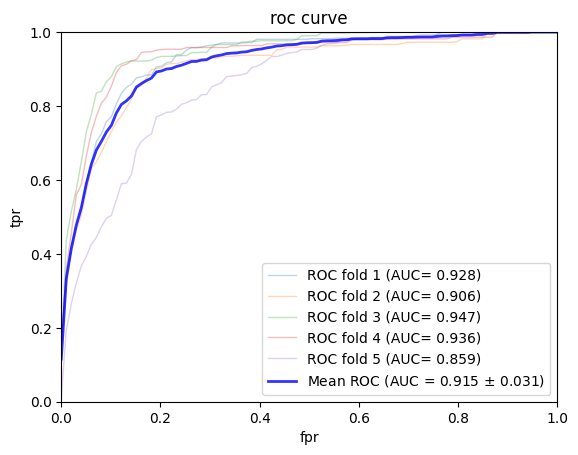

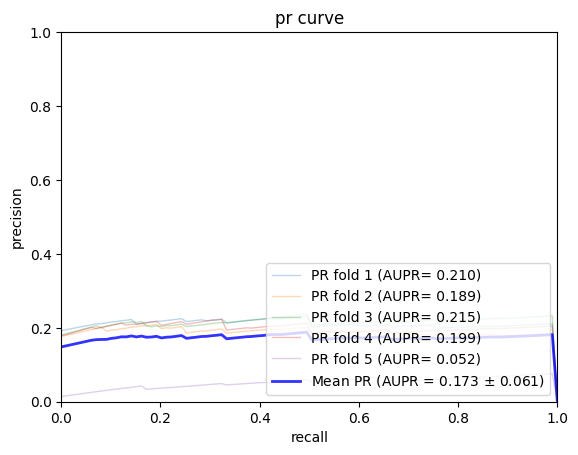

In [18]:
roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, 5)